Preprocessing done! Spiral + Meander merged into train/val.


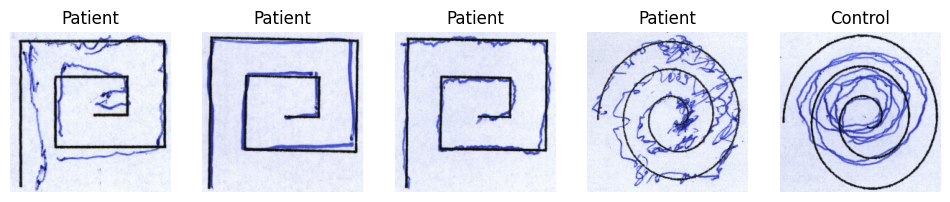

In [3]:

import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Directories
BASE_DIR = r"C:\Users\VINH\Desktop\SHAKYSHAKY\DATA"
OUTPUT_DIR = os.path.join(BASE_DIR, "mergedfff")

# Define source paths for Spiral and Meander datasets
DATA_SOURCES = {
    "control": [
        os.path.join(BASE_DIR, "Spiral", "SpiralControl"),
        os.path.join(BASE_DIR, "Meander", "MeanderControl")
    ],
    "patient": [
        os.path.join(BASE_DIR, "Spiral", "SpiralPatients"),
        os.path.join(BASE_DIR, "Meander", "MeanderPatients")
    ]
}

# Ensure output directories exist
for split in ["train", "val"]:
    for label in ["control", "patient"]:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Function to merge datasets and split into train/val
def merge_and_split(label, folders):
    all_images = []
    for folder in folders:
        files = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
        all_images.extend(files)
    
    # Split: 80% train, 20% val
    train_imgs, val_imgs = train_test_split(all_images, test_size=0.4, random_state=42)

    for img in train_imgs:
        shutil.copy(img, os.path.join(OUTPUT_DIR, "train", label, os.path.basename(img)))
    for img in val_imgs:
        shutil.copy(img, os.path.join(OUTPUT_DIR, "val", label, os.path.basename(img)))

# Process both classes (control and patient)
for label, folders in DATA_SOURCES.items():
    merge_and_split(label, folders)

print("Preprocessing done! Spiral + Meander merged into train/val.")

# Image preprocessing parameters
IMG_SIZE = (224, 224)  # Target size for ResNet
BATCH_SIZE = 32

# Function to preprocess images (RGB, resize, normalize)
def preprocess_image_rgb(img_path):
    img = cv2.imread(img_path)  # Load as BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Function to load dataset from directory
def load_dataset(directory):
    images, labels = [], []
    
    for label, class_name in enumerate(["control", "patient"]):  # Adjust folder names as needed
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            processed_img = preprocess_image_rgb(img_path)
            images.append(processed_img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load train, validation, and test sets
train_images, train_labels = load_dataset(os.path.join(OUTPUT_DIR, "train"))
val_images, val_labels = load_dataset(os.path.join(OUTPUT_DIR, "val"))

# Convert labels to categorical format
train_labels = to_categorical(train_labels, num_classes=2)
val_labels = to_categorical(val_labels, num_classes=2)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)

# Function to visualize sample images
def visualize_samples(images, labels, class_names=["Control", "Patient"], num_samples=5):
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(images), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[np.argmax(labels[idx])])
        plt.axis("off")
    plt.show()

# Show sample images
visualize_samples(train_images, train_labels)
